## ** Avance 4: Sistema de recomendacion **
## ** Instituto Tecnológico de Estudios Superiores de Monterrey **

### ** Equipo 40 **

Cecilia Acevedo Rodríguez- A01793953

Francisco Xavier Bastidas Moreno - A01794188

Ricardo Mar Cupido – A01795394

Edgar Gerardo Rojas Medina - A00840712


In [2]:
# Instalación de la biblioteca Surprise para sistemas de recomendación
!pip install surprise

# Instalación de la biblioteca LightFM para sistemas de recomendación híbridos
!pip install lightfm

In [41]:
# Importación de bibliotecas estándar
import pandas as pd               # Para manipulación y análisis de datos
import numpy as np                # Para operaciones numéricas
import seaborn as sns             # Para visualización de datos estadísticos
import matplotlib.pyplot as plt   # Para visualización gráfica

# Importación de funciones y clases de la biblioteca Surprise para sistemas de recomendación
from surprise import KNNWithMeans   # Algoritmo KNN con corrección de media
from surprise import SVD            # Factorización de matriz Singular Value Decomposition (SVD)
from surprise import Dataset        # Conjunto de datos de Surprise
from surprise import accuracy       # Funciones de precisión de Surprise
from surprise import Reader         # Lectura y análisis de archivos de datos específicos

# Importación de clases y funciones de scikit-learn para aprendizaje automático
from sklearn.cluster import KMeans                    # Algoritmo de agrupamiento K-Means
from sklearn.ensemble import GradientBoostingRegressor # Regresor de aumento de gradiente
from sklearn.model_selection import train_test_split  # División de conjunto de datos en entrenamiento y prueba
from sklearn.metrics import mean_squared_error        # Métrica de error cuadrático medio
from sklearn.metrics import mean_absolute_error       # Métrica de error absoluto medio

# Importación de bibliotecas para sistemas de recomendación híbridos
import lightgbm as lgb                          # Algoritmo LightFM para sistemas de recomendación híbridos



Se cargan los datos de la base de datos de Amazon, se limpian y se preparan para el sistema de recomendación.

In [4]:
#Cargar datos jsonl por partes
"""
from io import StringIO


def load_data(file, chunksize):
    data = pd.read_json(file, lines=True, chunksize=chunksize)
    return data

#'StringIO
amazon_json_io = StringIO()
amazon_metadata_json_io = StringIO()

#Cargar datos jsonl
amazon_json_io = load_data('./datos/Electronics.jsonl', 10000)
#amazon_metadata_json_io = load_data('./datos/meta_Electronics.jsonl', 10000)

#Json to DataFrame
amazon_df = pd.concat(amazon_json_io)
#amazon_metadata_df = pd.concat(amazon_metadata_json_io)

"""

"\nfrom io import StringIO\n\n\ndef load_data(file, chunksize):\n    data = pd.read_json(file, lines=True, chunksize=chunksize)\n    return data\n\n#'StringIO\namazon_json_io = StringIO()\namazon_metadata_json_io = StringIO()\n\n#Cargar datos jsonl\namazon_json_io = load_data('./datos/Electronics.jsonl', 10000)\n#amazon_metadata_json_io = load_data('./datos/meta_Electronics.jsonl', 10000)\n\n#Json to DataFrame\namazon_df = pd.concat(amazon_json_io)\n#amazon_metadata_df = pd.concat(amazon_metadata_json_io)\n\n"

Se crea un sample estratificado de los datos para poder trabajar con ellos, debido a que la base de datos es muy grande.

In [5]:
"""
from sklearn.model_selection import train_test_split
from collections import Counter

amazon_count = Counter(amazon_df['parent_asin'])
amazon_df = amazon_df[amazon_df['parent_asin'].map(amazon_count) > 1]

"""

"\nfrom sklearn.model_selection import train_test_split\nfrom collections import Counter\n\namazon_count = Counter(amazon_df['parent_asin'])\namazon_df = amazon_df[amazon_df['parent_asin'].map(amazon_count) > 1]\n\n"

Se alamacenan los datos en un archivo csv para poder trabajar con ellos en el siguiente avance.

In [6]:
"""
stratified_sample, _ = train_test_split(amazon_df, test_size=0.9, stratify=amazon_df['parent_asin'], random_state=42)
amazon_df = stratified_sample
amazon_df.to_csv('./datos/Electronics_stra.csv', index=False)
"""

"\nstratified_sample, _ = train_test_split(amazon_df, test_size=0.9, stratify=amazon_df['parent_asin'], random_state=42)\namazon_df = stratified_sample\namazon_df.to_csv('./datos/Electronics_stra.csv', index=False)\n"

In [7]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [8]:
# Lectura de datos desde una URL y carga en un DataFrame
amazon_df = pd.read_csv('https://raw.githubusercontent.com/MengtingWan/marketBias/master/data/df_electronics.csv')


In [9]:
amazon_df.head()

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0


In [10]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292954 entries, 0 to 1292953
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   item_id     1292954 non-null  int64  
 1   user_id     1292954 non-null  int64  
 2   rating      1292954 non-null  float64
 3   timestamp   1292954 non-null  object 
 4   model_attr  1292954 non-null  object 
 5   category    1292954 non-null  object 
 6   brand       331120 non-null   object 
 7   year        1292954 non-null  int64  
 8   user_attr   174124 non-null   object 
 9   split       1292954 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 98.6+ MB


In [11]:
amazon_df.describe()

,item_id,user_id,rating,year,split
count,1.292954e+06,1.292954e+06,1.292954e+06,1.292954e+06,1.292954e+06
mean,4.183588e+03,5.605127e+05,4.051482e+00,2.012938e+03,1.747587e-01
std,2.525346e+03,3.342374e+05,1.379732e+00,2.643513e+00,5.506810e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.999000e+03,0.000000e+00
25%,2.018000e+03,2.697482e+05,4.000000e+00,2.012000e+03,0.000000e+00
50%,3.930000e+03,5.518920e+05,5.000000e+00,2.014000e+03,0.000000e+00
75%,6.289000e+03,8.474858e+05,5.000000e+00,2.015000e+03,0.000000e+00
max,9.559000e+03,1.157632e+06,5.000000e+00,2.018000e+03,2.000000e+00


In [33]:
#Eliminar registros que tengan user_id, parent_asin y rating nulos
amazon_df = amazon_df.dropna(subset=['user_id', 'item_id', 'rating'])

In [13]:
# Calcular el número total de ratings en el conjunto de datos
n_ratings = len(amazon_df)

# Calcular el número de productos únicos (item_id) en el conjunto de datos
n_products = amazon_df["item_id"].nunique()

# Calcular el número de usuarios únicos (user_id) en el conjunto de datos
n_users = amazon_df["user_id"].nunique()

# Imprimir los resultados
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique products: {n_products}")
print(f"Number of unique users: {n_users}")


Number of ratings: 1292954
Number of unique products: 9560
Number of unique users: 1157633


In [56]:
# Calcular la frecuencia de ratings por usuario
user_freq = amazon_df[["user_id", "item_id"]].groupby("user_id").count().reset_index()

# Renombrar las columnas para mayor claridad
user_freq.columns = ["user_id", "n_ratings"]

# Mostrar las primeras filas del DataFrame resultante
user_freq.head()


,user_id,n_ratings
0,7,3
1,28,10
2,62,3
3,96,4
4,131,3


In [57]:
# Filtrar user_freq para incluir solo usuarios con al menos 3 ratings
user_freq = user_freq[user_freq["n_ratings"] >= 3]

# Filtrar amazon_df para incluir solo las filas de usuarios en user_freq
amazon_df = amazon_df[amazon_df["user_id"].isin(user_freq["user_id"])]

# Mostrar las primeras filas del nuevo DataFrame amazon_df filtrado
amazon_df.head()


,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
7,0,7,2.0,1999-07-13,Female,Portable Audio & Video,NaN,1999,NaN,0
28,0,28,2.0,1999-12-01,Female,Portable Audio & Video,NaN,1999,Female,0
62,0,62,5.0,2000-02-01,Female,Portable Audio & Video,NaN,1999,NaN,0
96,1,96,5.0,2000-05-05,Female,Computers & Accessories,HP,2000,NaN,0
131,7,131,4.0,2000-06-15,Female,Home Audio,Philips,2001,Male,0


In [16]:
print(f"Numero de ratings por usuario: {user_freq['n_ratings'].mean():.2f}.")

Numero de ratings por usuario: 3.60.


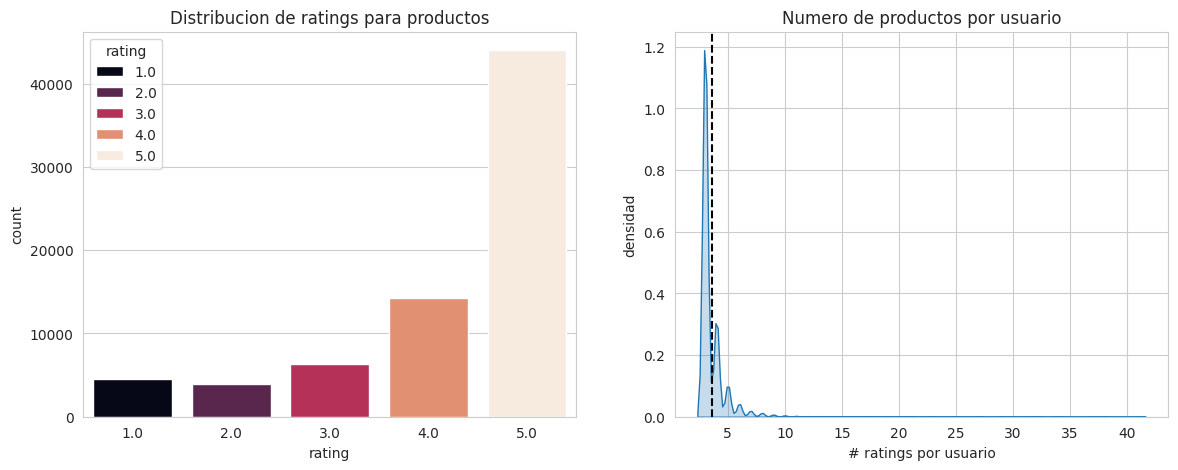

In [17]:
# Establecer el estilo de fondo de la gráfica
sns.set_style("whitegrid")

# Crear una figura con dos subtramas
plt.figure(figsize=(14,5))

# Subtrama 1: Distribución de ratings para productos
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=amazon_df, palette="rocket", hue="rating")
plt.title("Distribución de ratings para productos")

# Subtrama 2: Distribución del número de ratings por usuario
plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings por usuario")
plt.ylabel("Densidad")
plt.title("Número de ratings por usuario")

# Mostrar la gráfica
plt.show()

**Parte 4.- Preparación de datos**

In [58]:
# Paso 1: Seleccionar columnas específicas
prepared_df = amazon_df[["user_id", "item_id", "rating"]]

# Explicación del paso 1:
# - Utilizamos la sintaxis de indexación de pandas para seleccionar solo las columnas "user_id", "item_id" y "rating" del DataFrame amazon_df.
# - Esto crea un nuevo DataFrame llamado prepared_df que contiene solo estas tres columnas.

# Paso 2: Mostrar las primeras filas del nuevo DataFrame
prepared_df.head()

,user_id,item_id,rating
7,7,0,2.0
28,28,0,2.0
62,62,0,5.0
96,96,1,5.0
131,131,7,4.0


**Parte 5.- Modelado**

In [19]:
# Paso 1: Crear un objeto Reader
# Este paso define cómo interpretar la escala de calificación.
reader = Reader(rating_scale=(1, 5))

# Explicación del paso 1:
# - El objeto Reader se utiliza para leer los datos y especificar cómo se interpretan las calificaciones.
# - En este caso, se configura el parámetro rating_scale=(1, 5), lo que indica que las calificaciones van desde 1 hasta 5.

# Paso 2: Cargar datos desde DataFrame
# Aquí se carga el conjunto de datos desde el DataFrame preparado (prepared_df) utilizando el objeto Reader.
data = Dataset.load_from_df(prepared_df, reader)

# Explicación del paso 2:
# - Se utiliza el método load_from_df() de la clase Dataset para cargar datos desde el DataFrame preparado (prepared_df).
# - Se pasa el objeto Reader (definido en el paso 1) como argumento para especificar cómo deben interpretarse las calificaciones.
# - Esto crea un objeto Dataset que contiene los datos listos para ser utilizados en algoritmos de recomendación o análisis.


In [20]:
# Paso 1: Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
# Se divide el conjunto de datos `data` en conjuntos de entrenamiento (`train_x`) y prueba (`test_x`).
# Se utiliza train_test_split() de scikit-learn para realizar la división.
train_x, test_x = train_test_split(data, test_size=0.3, random_state=42)

# Explicación del paso 1:
# - train_test_split() es una función de scikit-learn que divide matrices o dataframes en subconjuntos aleatorios de entrenamiento y prueba.
# - Se pasa `data` como el conjunto de datos que se va a dividir.
# - test_size=0.3 indica que el 30% de los datos se utilizarán como conjunto de prueba (`test_x`), mientras que el 70% se utilizará como conjunto de entrenamiento (`train_x`).
# - random_state=42 se utiliza para asegurar que la división sea reproducible, es decir, que siempre genere la misma división aleatoria cuando se utilice el mismo valor.
# - `train_x` y `test_x` son los conjuntos de datos resultantes para entrenamiento y prueba respectivamente.


## Modelo Basico KNN

In [21]:
# Paso 1: Definir y entrenar el modelo
# Se define un modelo KNNWithMeans para realizar filtrado colaborativo.
model = KNNWithMeans(
    k=5, sim_options={"name": "cosine", "user_based": False})

model.fit(train_x)

# Explicación del paso 1:
# - Se instancia un modelo KNNWithMeans para realizar filtrado colaborativo.
# - `k=5` especifica el número de vecinos más cercanos a considerar para calcular las predicciones.
# - `sim_options={"name": "cosine", "user_based": False}` configura las opciones de similitud del modelo, utilizando la similitud coseno entre elementos (en lugar de usuarios) para calcular similitudes entre elementos.
# - `model.fit(train_x)` entrena el modelo utilizando el conjunto de entrenamiento `train_x`.

# Paso 2: Realizar predicciones
# Se utilizan las predicciones del modelo entrenado en el conjunto de prueba `test_x`.
predictions = model.test(test_x)

# Explicación del paso 2:
# - `model.test(test_x)` genera predicciones para el conjunto de prueba `test_x` utilizando el modelo entrenado.
# - `predictions` contiene los resultados de las predicciones, que incluyen las calificaciones predichas y las calificaciones reales en el conjunto de prueba.


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
# Calcular métricas de evaluación

# Paso 1: Calcular RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)

# Explicación del paso 1:
# - `accuracy.rmse(predictions)` calcula el RMSE (Root Mean Squared Error) utilizando las predicciones `predictions`.
# - RMSE es una métrica comúnmente utilizada para evaluar la precisión de las predicciones en problemas de recomendación y regresión.

# Paso 2: Calcular MAE (Mean Absolute Error)
mae = accuracy.mae(predictions)

# Explicación del paso 2:
# - `accuracy.mae(predictions)` calcula el MAE (Mean Absolute Error) utilizando las predicciones `predictions`.
# - MAE es otra métrica común que mide el promedio de las diferencias absolutas entre las predicciones y los valores reales.

# Paso 3: Calcular MSE (Mean Squared Error)
mse = accuracy.mse(predictions)

# Explicación del paso 3:
# - `accuracy.mse(predictions)` calcula el MSE (Mean Squared Error) utilizando las predicciones `predictions`.
# - MSE es una métrica que mide el promedio de los cuadrados de las diferencias entre las predicciones y los valores reales.


RMSE: 1.2424
MAE:  0.8910
MSE: 1.5437


1.5436585856733978

In [23]:
def encuentra_productos_similares(model, product_id, n=10):
    """
    Encuentra productos similares a un producto dado utilizando un modelo de filtrado colaborativo.

    Parámetros:
    - model: Modelo entrenado de filtrado colaborativo (por ejemplo, KNNWithMeans).
    - product_id: ID del producto para el cual se desea encontrar productos similares.
    - n: Número de productos similares a encontrar (por defecto 10).

    Retorna:
    - Lista de IDs de productos similares.

    """
    # Convertir el ID del producto al ID interno utilizado por el modelo
    product_inner_id = model.trainset.to_inner_iid(product_id)

    # Obtener los IDs internos de los productos vecinos más cercanos
    product_neighbors = model.get_neighbors(product_inner_id, k=n)

    # Convertir los IDs internos de los vecinos a IDs originales (raw)
    product_neighbors = [model.trainset.to_raw_iid(inner_id) for inner_id in product_neighbors]

    return product_neighbors


In [24]:
# Definir el ID del producto y encontrar productos similares
product_id = 7
product_neighbors = encuentra_productos_similares(model, product_id)

# Imprimir los productos similares encontrados
print(f"Productos similares a {product_id}:")
for product in product_neighbors:
    print(product)


Productos similares a 7:
468
3252
5755
8074
7008
274
3288
3665
6446
3264


## Modelo Avanzado SVD

In [25]:
# Paso 1: Definir y entrenar el modelo SVD (Singular Value Decomposition)
# Se instancia un modelo SVD con parámetros específicos y se entrena con los datos de entrenamiento.
model = SVD(n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.02, random_state=42)

model.fit(train_x)

# Explicación del paso 1:
# - Se utiliza el algoritmo SVD (Singular Value Decomposition) para el filtrado colaborativo.
# - `n_factors=50` especifica el número de factores latentes a considerar.
# - `n_epochs=10` indica el número de épocas (iteraciones) para entrenar el modelo.
# - `lr_all=0.005` es la tasa de aprendizaje para la optimización del modelo.
# - `reg_all=0.02` es el término de regularización para mitigar el sobreajuste.
# - `random_state=42` se utiliza para asegurar la reproducibilidad del entrenamiento.

# Paso 2: Realizar predicciones
# Se generan predicciones sobre el conjunto de prueba utilizando el modelo entrenado.
predictions = model.test(test_x)

# Explicación del paso 2:
# - `model.test(test_x)` genera predicciones utilizando el modelo entrenado sobre el conjunto de prueba `test_x`.
# - `predictions` contiene los resultados de las predicciones, que incluyen las calificaciones predichas y las calificaciones reales en el conjunto de prueba.


In [26]:
# Calcular métricas de evaluación

# Paso 1: Calcular RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)

# Explicación del paso 1:
# - `accuracy.rmse(predictions)` calcula el RMSE (Root Mean Squared Error) utilizando las predicciones `predictions`.
# - RMSE es una métrica comúnmente utilizada para evaluar la precisión de las predicciones en problemas de recomendación y regresión.

# Paso 2: Calcular MAE (Mean Absolute Error)
mae = accuracy.mae(predictions)

# Explicación del paso 2:
# - `accuracy.mae(predictions)` calcula el MAE (Mean Absolute Error) utilizando las predicciones `predictions`.
# - MAE es otra métrica común que mide el promedio de las diferencias absolutas entre las predicciones y los valores reales.

# Paso 3: Calcular MSE (Mean Squared Error)
mse = accuracy.mse(predictions)

# Explicación del paso 3:
# - `accuracy.mse(predictions)` calcula el MSE (Mean Squared Error) utilizando las predicciones `predictions`.
# - MSE es una métrica que mide el promedio de los cuadrados de las diferencias entre las predicciones y los valores reales.


RMSE: 1.1482
MAE:  0.8720
MSE: 1.3183


1.3183317239529388

In [27]:
def obtener_recomendaciones_producto(model, user_id, n=10):
    """
    Genera recomendaciones de productos para un usuario utilizando un modelo de filtrado colaborativo.

    Parámetros:
    - model: Modelo entrenado de filtrado colaborativo (por ejemplo, SVD).
    - user_id: ID del usuario para el cual se desean obtener recomendaciones.
    - n: Número de recomendaciones a generar (por defecto 10).

    Retorna:
    - Lista de IDs de productos recomendados para el usuario.

    """
    # Obtener una lista de todos los IDs de los productos en el conjunto de entrenamiento
    item_ids = model.trainset.all_items()

    # Obtener predicciones de calificación para productos que el usuario no ha calificado aún
    predictions = [(model.trainset.to_raw_iid(item_id), model.predict(user_id, item_id).est) for item_id in item_ids]

    # Ordenar las predicciones por calificación de mayor a menor y obtener los primeros n productos
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:n]

    # Devolver los IDs de los productos recomendados
    return [item_id for (item_id, _) in top_n]

# Ejemplo de uso:
user_id = 7
print(f"Recomendaciones para el usuario {user_id}:")
for item in obtener_recomendaciones_producto(model, user_id):
    print(item)


Recomendaciones para el usuario 7:
5501
2784
1061
8456
4704
2477
5673
6012
8504
822


# Modelo K-Means #

In [30]:
# Se instancia un modelo K-Means con parámetros específicos y se entrena con la matriz de dispersión
kmeans = KMeans(n_clusters=1000, random_state=42, tol=1e-4, init='k-means++', max_iter=300, n_init=10)

# Paso 2: Preparar la matriz de dispersión
# Se crea una matriz de dispersión (user-item matrix) a partir del DataFrame amazon_df
matriz_dispersion = amazon_df.pivot_table(index="user_id", columns="item_id", values="rating")

# Se llenan los valores NaN (si existen) con 0
matriz_dispersion = matriz_dispersion.fillna(0)

# Paso 3: Entrenar el modelo K-Means con la matriz de dispersión
kmeans.fit(matriz_dispersion)

# Paso 4: Hacer predicciones (asignación de clusters)
predictions = kmeans.predict(matriz_dispersion)

In [34]:
# Calcular el error de reconstrucción
reconstruction_error = np.sum((matriz_dispersion - kmeans.cluster_centers_[predictions])**2, axis=1)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(np.zeros_like(reconstruction_error), reconstruction_error))
print(f"RMSE: {rmse}")

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(np.zeros_like(reconstruction_error), reconstruction_error)
print(f"MSE: {mse}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(np.zeros_like(reconstruction_error), reconstruction_error)
print(f"MAE: {mae}")

RMSE: 51.05317916032947
MSE: 2606.4271023766996
MAE: 43.809865122872736


# Modelo LightGBM #

In [51]:
#Dividir datos
train_x, test_x = train_test_split(amazon_df, test_size=0.3, random_state=42)

#Crear dataset
train_data = lgb.Dataset(train_x[["user_id", "item_id"]], label=train_x["rating"])
test_data = lgb.Dataset(test_x[["user_id", "item_id"]], label=test_x["rating"])

#Parametros
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0
}

#Entrenar modelo
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])

#Predecir
predictions = model.predict(test_x[["user_id", "item_id"]], num_iteration=model.best_iteration)




In [52]:
# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(predictions, test_x["rating"]))
print(f"RMSE: {rmse:.2f}")

# Calcular MAE (Mean Absolute Error)
mae = np.mean(np.abs(predictions - test_x["rating"]))
print(f"MAE: {mae:.2f}")

# Calcular MSE (Mean Squared Error)
mse = np.mean((predictions - test_x["rating"])**2)
print(f"MSE: {mse:.2f}")



RMSE: 1.19
MAE: 0.92
MSE: 1.41


# Gradient Boost #

In [60]:
# Paso 1: Preparar los datos
X = amazon_df[["user_id", "item_id"]]  # Características de entrada
y = amazon_df["rating"]  # Variable objetivo

# Paso 2: Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 3: Entrenar el modelo Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Paso 4: Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)


In [55]:
# Paso 5: Calcular métricas de evaluación

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse:.2f}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae:.2f}")

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse:.2f}")

RMSE: 1.18
MAE: 0.92
MSE: 1.38
